In [1]:
%matplotlib inline
#%matplotlib notebook
import matplotlib
#matplotlib.use('TkAgg')
import numpy as np
import matplotlib.pyplot as pl
from astropy.io import fits
from astropy import wcs
import pandas as pd
import sys
from tqdm import tqdm
from astropy.visualization import ZScaleInterval
from glob import glob
import csv
#import seaborn as sns

from multiprocessing import Pool
import time as tm

from uncertainties import ufloat
from scipy import constants as con
#import pyregion

In [2]:
targ_rv=-4.0405
targ_rv_e =0.0756
ref_rv = -110.345 
ref_rv_e = 0.0119

In [3]:
#import velocity_correction as vc

In [5]:
data_targ=np.loadtxt('../data/ccf/ccf_median_target.dat')
data_ref = np.loadtxt('../data/ccf/ccf_median_ref.dat')
data_targ_joinref = np.loadtxt('../data/ccf/ccf_median_target_joinref.dat')

No handles with labels found to put in legend.


Text(0, 0.5, 'Cross Correlation')

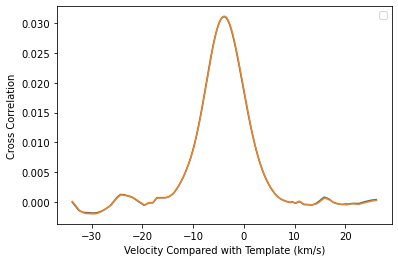

In [6]:
for data in [data_targ_joinref, data_targ]:
    pl.plot(data[:,0],data[:,1])
pl.legend()
pl.xlabel("Velocity Compared with Template (km/s)")
pl.ylabel("Cross Correlation")

In [7]:
import matplotlib
matplotlib.rcParams.update({'font.size': 20})
pl.rcParams['ytick.labelsize'] = 'medium'
pl.rcParams['xtick.labelsize'] ='medium'
fontsize=20

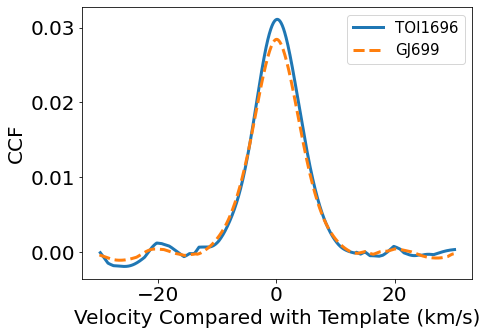

In [22]:
pl.figure(figsize=(7,5))

labels = ['TOI1696', 'GJ699']
for data, rv, lb, st in zip([data_targ_joinref, data_ref],[targ_rv, ref_rv], labels, ['-','--']):
    pl.plot(data[:,0]-rv,data[:,1], st, label=lb, lw=3)
pl.legend(fontsize=15)
pl.xlabel("Velocity Compared with Template (km/s)")
pl.ylabel("CCF")

pl.savefig('CCF.pdf', bbox_inches='tight')

ccfのFWHMを測定 → 同じ幅であることを根拠にする
ccfの幅が分光器の速度分解能に対して
分解能70000がどれくらいの速度に対応するか
わざと速度(+強度コントラスト)をずらして足し合わせたら擬似的に連星のスペクトルにできる→どこまで検出可能か、を言える

GJ699: 自転が遅い(1km/s以下)→自転は測定できない。スペクトルの広がりは分解能できまる
GJ699と同じくらいFWHMが小さいのだから、このターゲットも自転は遅いし、singleであると言う根拠になる

ガタガタをきれいにするには…
- 事前にhot pixelなどをmaskする
- wave_ranges = np.array([ [988, 993], [995, 1000],)をかえる: 大気吸収の激しいところは除いて波長範囲を増やしていく
- ↑ノーマライズがうまくいってなさそうな領域は事前に除く(その説明をつけて)
- GJ699のときのデータを今の高速自転星のデータを使って補正しているせいかも

GJ699について
- 足し合わせたほうがいいはいい、そのときはNanにかえる → 変わらなかった！
- 30分程度だったら地球運動の効果はあまりかわらないけど → 効果はほんとうになかった！

In [9]:
from scipy.optimize import curve_fit
from scipy.stats import norm
 
# gaussian function
def gaussian_func(x, amp, mu, sigma):
    return amp * np.exp( - (x - mu)**2 / (2 * sigma**2))

#def two_gaussian(x, amp1, mu1, sigma1, amp2, mu2, sigma2):
    

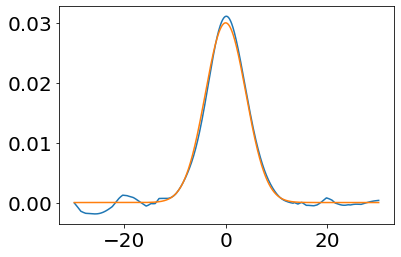

In [10]:
data = data_targ_joinref 
x = data[:,0]-targ_rv
y = data[:,1]
pl.plot(x,y)

amp_init = 0.03
mu_init = 0.
sigma_init = 4.
y_init = gaussian_func(x, amp_init, mu_init, sigma_init)
pl.plot(x, y_init)

バックグラウンドは0になっているとして大丈夫かな？？

In [11]:
#Initial guess
guess = []
guess.append([amp_init, mu_init, sigma_init])

#バックグラウンドの初期値
#background = 0

popt, pcov = curve_fit(gaussian_func, x, y, p0=guess)

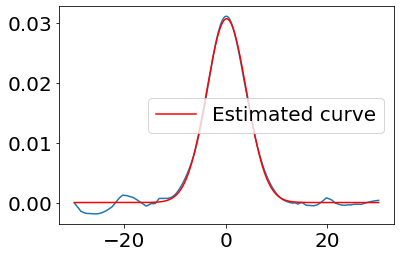

In [12]:
pl.plot(x,y)

# plot result
xd = np.arange(x.min(), x.max(), 0.01)
estimated_curve = gaussian_func(xd, popt[0],popt[1],popt[2])
pl.plot(xd, estimated_curve, label="Estimated curve",color="r")
pl.legend()
#pl.savefig("gaussian_fitting.png")

In [13]:
data = data_ref
x = data[:,0]-ref_rv
y = data[:,1]

#Initial guess - 同じのでいい
guess = []
guess.append([amp_init, mu_init, sigma_init])

#バックグラウンドの初期値
#background = 0

popt_ref, pcov_ref = curve_fit(gaussian_func, x, y, p0=guess)

In [14]:
popt_ref

array([0.02772626, 0.0203125 , 4.08266624])

In [15]:
popt

array([0.03068414, 0.18459397, 3.92035629])

## FWHM

In [16]:
sigma = popt[2]
fwhm = 2 * sigma * (2 * np.log(2.) )**0.5
fwhm

9.231733582853353

In [17]:
sigma = popt_ref[2]
fwhm = 2 * sigma * (2 * np.log(2.) )**0.5
fwhm

9.613944306703646

ちなみにFWHM~2.35σ http://hooktail.sub.jp/mathInPhys/fwhmsigma/

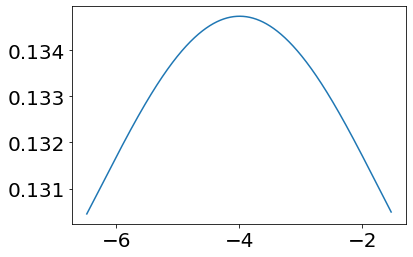

In [18]:
bestfit_ccf = pd.read_csv('bestfit_ccf.dat', sep=' ', header=None)
pl.plot(bestfit_ccf[0],bestfit_ccf[1]) 

これは何を意味するんや？

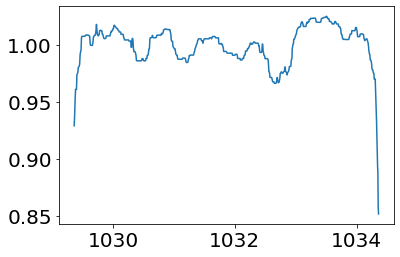

In [19]:
blaze_fit = pd.read_csv('blaze_fit.dat', sep=' ', header=None)
pl.plot(blaze_fit[0],blaze_fit[1]) 